# TP04 MapReduce - Multiplication Matricielle
# Matrice A et B complètes

## Chargement des matrices A et B

In [1]:
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [16]:
A = np.load("A.npy")
B = np.load("B.npy")

# Affichage des dimensions pour vérification
print(f"Matrice A : {A.shape}")
print(f"Matrice B : {B.shape}")

Matrice A : (100, 10000)
Matrice B : (10000, 100)


In [3]:
C_numpy = A @ B

## Questions

1. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **multithreading** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$

In [12]:
def compute_element(args):
    """ Calcule un élément c_ij du produit matriciel C = A * B """
    A, B, i, j = args
    return i, j, sum(A[i, k] * B[k, j] for k in range(A.shape[1]))

def Produit_mt(A, B, num_workers):
    C = np.zeros((A.shape[0], B.shape[1]))
    tasks = [(A, B, i, j) for i in range(A.shape[0]) for j in range(B.shape[1])]
    
    tic = time.time()
    with ThreadPoolExecutor(max_workers=num_workers) as t_exe:
        results = t_exe.map(compute_element, tasks)
    toc = time.time()
    
    for i, j, value in results:
        C[i, j] = value
    
    return C, toc - tic


In [ ]:
%time C_mt, _ = Produit_mt(A,B)

<generator object Executor.map.<locals>.result_iterator at 0x7e7ca278f4c0>
22.47 seconds for MT
CPU times: user 22.4 s, sys: 147 ms, total: 22.6 s
Wall time: 22.5 s


2. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **mutiprocessing** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$

In [13]:
def Produit_mp(A, B, num_workers):
    C = np.zeros((A.shape[0], B.shape[1]))
    tasks = [(A, B, i, j) for i in range(A.shape[0]) for j in range(B.shape[1])]
    
    tic = time.time()
    with ProcessPoolExecutor(max_workers=num_workers) as p_exe:
        results = p_exe.map(compute_element, tasks)
    toc = time.time()
    
    for i, j, value in results:
        C[i, j] = value
    
    return C, toc - tic

In [ ]:
%time C_mp, _ = Produit_mp(A,B)

273.28 seconds for MP
CPU times: user 37.5 s, sys: 2min 10s, total: 2min 47s
Wall time: 4min 33s


3.Comparer les temps de restitution des différentes implémentations en variant le nombre de workers.

In [14]:
def measure_time(function, num_workers, A, B):
    _, duration = function(A, B, num_workers)
    return duration

def compare_performance(A, B, worker_counts):
    mp_times = []
    mt_times = []
    
    for num_workers in worker_counts:
        mp_times.append(measure_time(Produit_mp, num_workers, A, B))
        mt_times.append(measure_time(Produit_mt, num_workers, A, B))
    
    plt.figure(figsize=(10, 5))
    plt.plot(worker_counts, mp_times, label='Multiprocessing', marker='o')
    plt.plot(worker_counts, mt_times, label='Multithreading', marker='s')
    plt.xlabel('Number of Workers')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Times')
    plt.legend()
    plt.grid()
    plt.show()

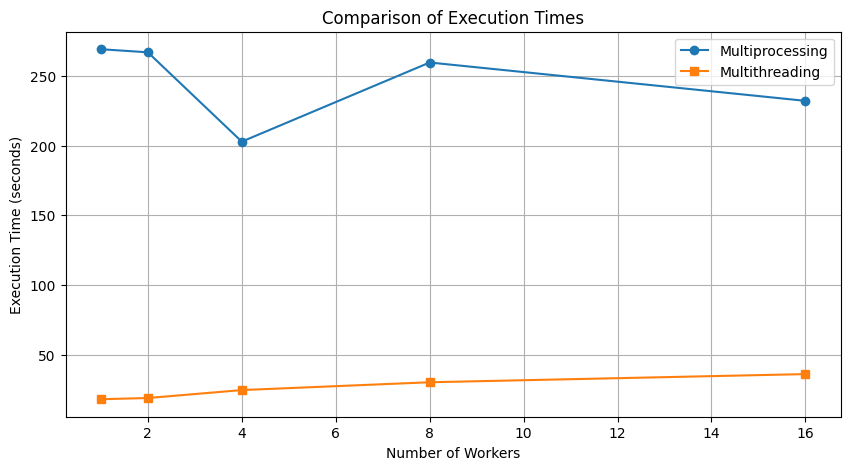

In [17]:
worker_counts = [1, 2, 4, 8, 16]
compare_performance(A, B, worker_counts)

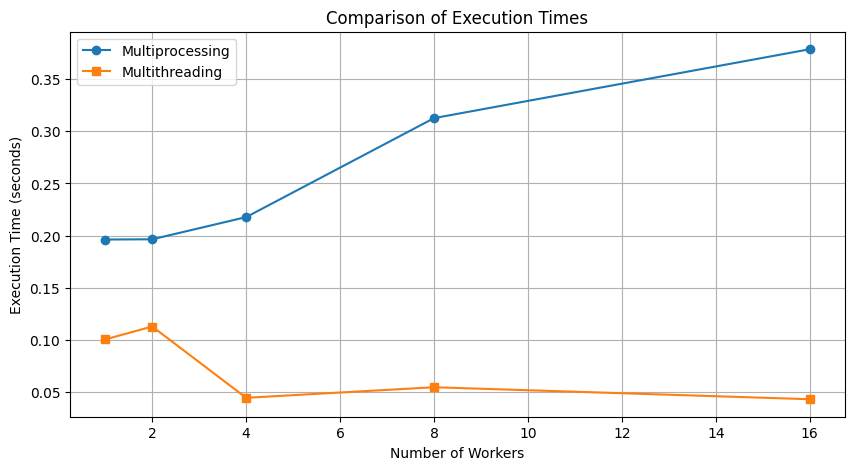

In [18]:
A = np.random.rand(50, 50)
B = np.random.rand(50, 50)
worker_counts = [1, 2, 4, 8, 16]
compare_performance(A, B, worker_counts)

The execution time initially decreases in MT for the smaller matriz, indicating a performance gain when adding more threads. However, as the number of threads increases, the time does not improve significantly. This suggests that the GIL limits multithreading performance.

The execution time increases with the number of processes, which is counterintuitive. This may occur because creating multiple processes has a high overhead cost (creating new processes, communication between them, etc.). For small matrices, the coordination cost may be higher than the benefit of parallelism.
